# Quick start

Python version: anaconda install of python3.9<br>
JWST pipeline version: 1.4.3<br>
Author: DG


Start by importing the STScI pipeline and configuring our CRDS cache. Here the calwebb_detector1 contains the stage 1 steps and calwebb_spec2 contains the stage 2 steps.

In [ ]:
import os
from jwst import datamodels
from jwst.pipeline import calwebb_detector1
from jwst.pipeline import calwebb_spec2


os.environ['CRDS_PATH'] = '/Users/davidgrant/Work/Code/ResearchScience/MIRI-HelloWorld/crds_cache'
os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

Next, configure the path to your data. Observations are chunked into ~2 GB files and so for the purposes of this tutorial only the first data chunk is loaded.

In [ ]:
RAW_DATA_DIR = '/Users/davidgrant/Work/Data/Observations/MIRI_SIM/raw'

# Load first data chunk.
raw_data_files = [os.path.join(RAW_DATA_DIR, f) for f in sorted(os.listdir(RAW_DATA_DIR))]
dm_raw = datamodels.RampModel(raw_data_files[0])

Finally, instantiate the STScI pipeline steps.

In [ ]:
# Instantiate STScI steps for MIRI LRS stage 1.
stsci_group_scale = calwebb_detector1.group_scale_step.GroupScaleStep()
stsci_dq_init = calwebb_detector1.dq_init_step.DQInitStep()
stsci_saturation = calwebb_detector1.saturation_step.SaturationStep()
stsci_linearity = calwebb_detector1.linearity_step.LinearityStep()
stsci_dark_current = calwebb_detector1.dark_current_step.DarkCurrentStep()
stsci_refpix = calwebb_detector1.refpix_step.RefPixStep()
stsci_jump = calwebb_detector1.jump_step.JumpStep()
stsci_ramp_fit = calwebb_detector1.ramp_fit_step.RampFitStep()
stsci_gain_scale = calwebb_detector1.gain_scale_step.GainScaleStep()

# Instantiate STScI steps for MIRI LRS stage 2.
stsci_assign_wcs = calwebb_spec2.assign_wcs_step.AssignWcsStep()
stsci_srctype = calwebb_spec2.srctype_step.SourceTypeStep()
stsci_flat_field = calwebb_spec2.flat_field_step.FlatFieldStep()
stsci_extract_1d = calwebb_spec2.extract_1d_step.Extract1dStep()

### STScI stage 1 pipline

First, consider a typical set of stage 1 steps using only the STScI pipeline.

In [ ]:
# Pure STScI stage 1 reduction.
proc = stsci_dq_init.call(dm_raw)
proc = stsci_saturation.call(proc)
proc = stsci_linearity.call(proc)
proc = stsci_dark_current.call(proc)
proc = stsci_refpix.call(proc)
proc = stsci_jump.call(proc, rejection_threshold=4.0)
_, stage_1_output = stsci_ramp_fit.call(proc)

### Custom stage 1 pipline

Now, consider a custom set of stage 1 steps combining the STScI pipeline with ExoTiC-MIRI. Here we add a regroup step at the start of the reduction, and swap in the custom reference pixel step for the STScI one. All stage 1 ExoTiC-MIRI steps return the same data structures as STScI steps and so they are fully interoperable.

In [ ]:
from exotic_miri import RegroupStep, ReferencePixelStep


# Instantiate custom steps for MIRI LRS stage 1.
exotic_regroup = RegroupStep()
exotic_refpix = ReferencePixelStep()

# Custom stage 1 reduction.
proc = exotic_regroup.call(dm_raw, n_groups=15)
proc = stsci_dq_init.call(proc)
proc = stsci_saturation.call(proc)
proc = stsci_linearity.call(proc)
proc = stsci_dark_current.call(proc)
proc = exotic_refpix.call(proc, smoothing_length=11, odd_even_rows=True)
proc = stsci_jump.call(proc, rejection_threshold=4.0)
_, custom_stage_1_output = stsci_ramp_fit.call(proc)

### STScI stage 2 pipline

Second, consider a typical set of stage 2 steps using only the STScI pipeline.

In [ ]:
# Pure STScI stage 2 reduction.
proc = stsci_assign_wcs.call(stage_1_output)
proc = stsci_srctype.call(proc)
proc = stsci_flat_field.call(proc)
stage_2_output = stsci_extract_1d.call(proc)

### Custom stage 2 pipline

Now, consider a custom set of stage 2 steps combining the STScI pipeline with ExoTiC-MIRI. Here we swap out the extract 1d step, and replace it with a custom extraction step tailored specifically for MIRI TSO analysis.

NB. the extracted spectra from the custom extract 1d step are stored as a list of pandas dataframes in the attribute MultiSpecModel.spectra. Each dataframe represents the spectrum of one integration.

In [ ]:
from exotic_miri import Extract1dStep


# Instantiate custom steps for MIRI LRS stage 2.
exotic_extract_1d = Extract1dStep()

# Custom stage 1 reduction.
proc = stsci_assign_wcs.call(custom_stage_1_output)
proc = stsci_srctype.call(proc)
proc = stsci_flat_field.call(proc)
custom_stage_2_output = exotic_extract_1d.call(
    proc,
    bkg_region=[8, 22, 52, 70],
    bkg_algo='polynomial',
    bkg_poly_order=1,
    bkg_smoothing_length=50,
    extract_region_width=19,
    extract_algo='optimal',
    extract_poly_order=8)

Index(['pixels', 'wavelengths', 'flux', 'flux_error'], dtype='object')


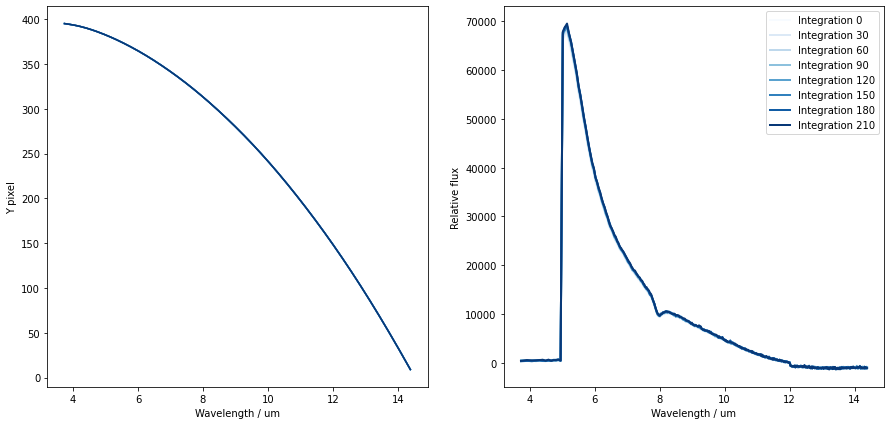

In [27]:
from matplotlib import cm
import matplotlib.pyplot as plt


# Show output data columns.
print(custom_stage_2_output.spectra[0].columns)

# Draw results for every 30th integration in data chunk.
fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
cmap = cm.Blues
for idx_int in range(0, len(custom_stage_2_output.spectra), 30):
    
    # Plot pixel to wavelength map.
    ax1.plot(custom_stage_2_output.spectra[idx_int]['wavelengths'],
             custom_stage_2_output.spectra[idx_int]['pixels'], 
             c=cmap(idx_int / len(custom_stage_2_output.spectra)))
    
    # Plot spectrum.
    ax2.plot(custom_stage_2_output.spectra[idx_int]['wavelengths'],
             custom_stage_2_output.spectra[idx_int]['flux'], 
             c=cmap(idx_int / len(custom_stage_2_output.spectra)), 
             lw=2, label='Integration {}'.format(idx_int))
    
ax1.set_xlabel('Wavelength / um')
ax1.set_ylabel('Y pixel')
ax2.set_xlabel('Wavelength / um')
ax2.set_ylabel('Relative flux')
plt.legend(loc='upper right')
plt.show()